In [1]:
import pandas as pd

df = pd.read_csv('df_sans_meteo.csv',index_col=0)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7939 entries, 0 to 9113
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7939 non-null   object 
 1   release_date           7939 non-null   object 
 2   genre                  7939 non-null   object 
 3   duration               7939 non-null   object 
 4   director               7939 non-null   object 
 5   producers              7939 non-null   object 
 6   cast                   7939 non-null   object 
 7   nationality            7939 non-null   object 
 8   distributor            7939 non-null   object 
 9   box_office_title       7939 non-null   object 
 10  box_office_first_week  7939 non-null   int64  
 11  press_eval             7939 non-null   object 
 12  viewers_eval           7939 non-null   object 
 13  views                  7939 non-null   float64
 14  budget                 7939 non-null   object 
dtypes: f

In [3]:
df.shape

(7939, 15)

## Nettoyage

In [4]:
# Modification du format de la date

df['release_date'] = pd.to_datetime(df['release_date'])

In [5]:
# Harmonisation des intitulés des genres

def replace_drama(genres_list):
    if 'Drama' in genres_list:
        genres_list = [genre.replace('Drama', 'Drame') for genre in genres_list]
    return genres_list

# Appliquer la fonction personnalisée sur la colonne "genres"
df['genre'] = df['genre'].str.split(', ').apply(replace_drama).str.join(', ')


In [6]:
def convert_to_minutes(time_str):
    if 'h' in time_str and 'min' in time_str:
        time_parts = time_str.split('h')
        hours = int(time_parts[0])
        minutes = int(time_parts[1].replace('min', '').strip())
    elif 'h' in time_str:
        hours = int(time_str.replace('h', '').strip())
        minutes = 0
    else:
        raise ValueError("Format de temps invalide. Utilisez '1h' ou '1h 20min'.")

    total_minutes = hours * 60 + minutes

    return total_minutes





In [7]:
df['duration'] = df['duration'].apply(convert_to_minutes)

In [8]:
df = df[df['duration']>0]

In [9]:
df = df.drop(['box_office_title'],axis=1)

In [10]:
df['press_eval'] = df['press_eval'].str.replace(',', '.')
df['press_eval'] = df["press_eval"].astype('float')

In [11]:
df = df[df['viewers_eval'] != '--']
df['viewers_eval'] = df['viewers_eval'].str.replace(',', '.')
df['viewers_eval'] = df["viewers_eval"].astype('float')

In [12]:
df = df[df['budget'] != 'Erreur lors de la requête API 2.']
df['budget'] = df['budget'].astype('float')

In [13]:
def get_season(release_date):
    month = release_date.month
    if month >=3 and month <= 5:
        return "Spring"
    elif month >=6 and month <= 8:
        return "Summer"
    elif month >=9 and month <= 11:
        return "Autumn"
    else : 
        return "Winter"

In [14]:
df['release_date'] = pd.to_datetime(df['release_date'])
df['season'] = df['release_date'].apply(get_season)

In [15]:
# Supprimer les lignes contenant les mots 'entrées' ou 'nomination' dans la colonne 'distributor'
df = df[~df['distributor'].str.contains('entrées|nomination', case=False)]


In [16]:
df['distributor'] = df['distributor'].str.replace('/', ',')

## Analyse

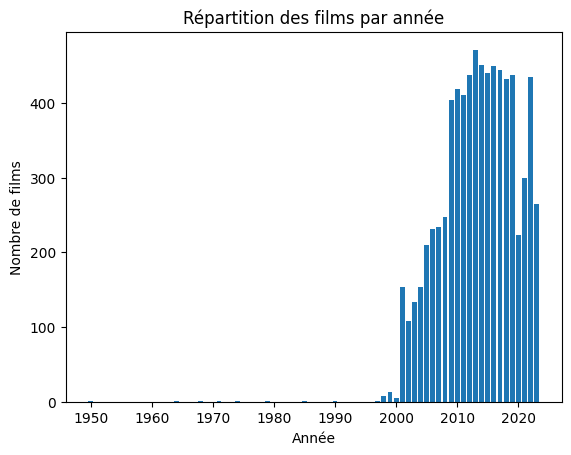

In [17]:
import matplotlib.pyplot as plt 

# Extraire l'année à partir de la colonne "release_date"
df['year'] = df['release_date'].dt.year

# Utiliser groupby() pour regrouper les films par année et compter le nombre de films dans chaque année
films_by_year = df.groupby('year').size()

# Tracer le graphique en utilisant matplotlib
plt.bar(films_by_year.index, films_by_year.values)
plt.xlabel('Année')
plt.ylabel('Nombre de films')
plt.title('Répartition des films par année')
plt.show()


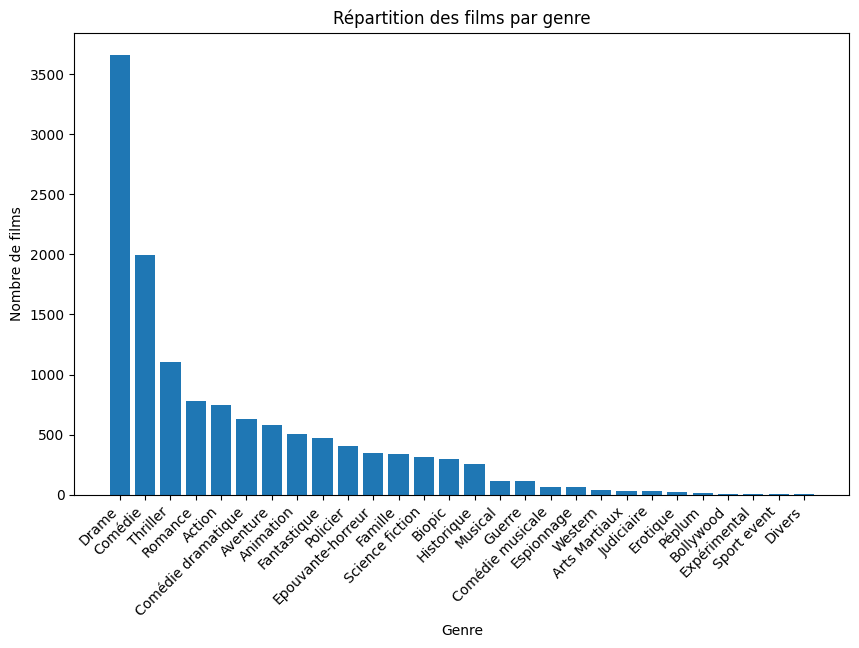

In [18]:
# Compter le nombre de films pour chaque genre
genres_counts = df['genre'].str.split(', ', expand=True).stack().value_counts()

# Tracer le graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(genres_counts.index, genres_counts.values)
plt.xlabel('Genre')
plt.ylabel('Nombre de films')
plt.title('Répartition des films par genre')
plt.xticks(rotation=45, ha='right')
plt.show()

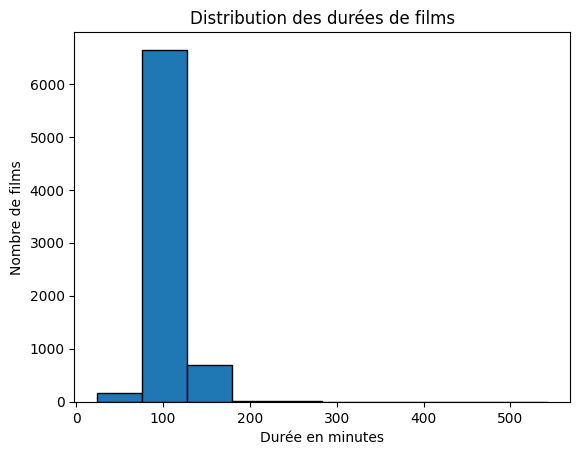

In [19]:
plt.hist(df['duration'], bins=10, edgecolor='black')

# Ajouter des étiquettes et un titre
plt.xlabel('Durée en minutes')
plt.ylabel('Nombre de films')
plt.title('Distribution des durées de films')

# Afficher le graphique
plt.show()

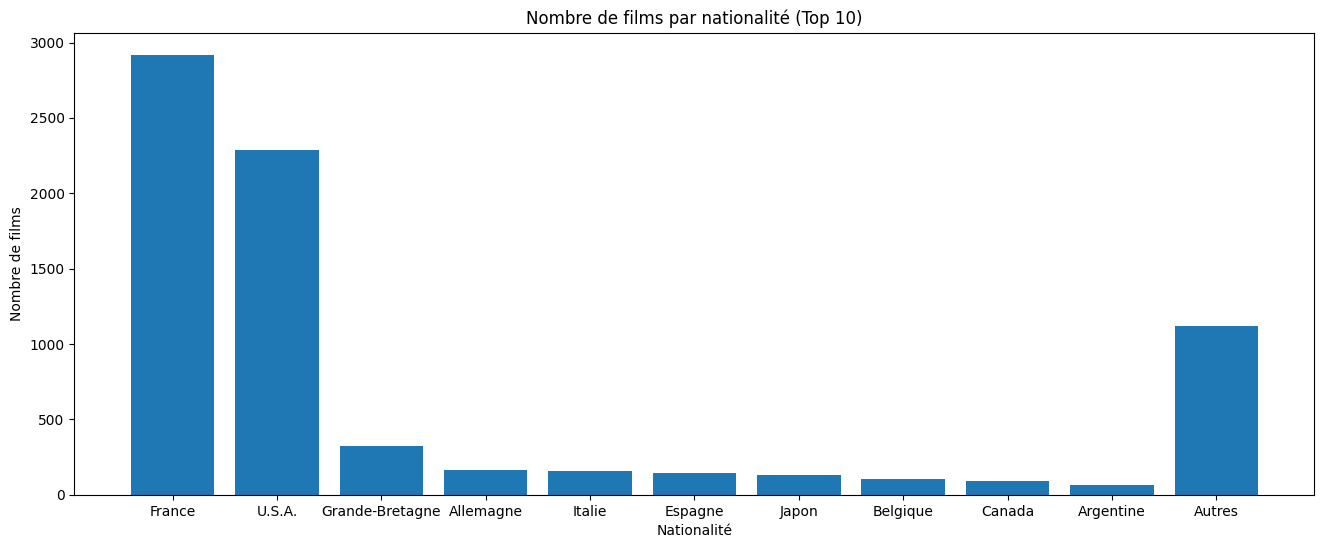

In [20]:
films_by_nation = df['nationality'].value_counts()

top_nations = films_by_nation[:10]
other_nations = films_by_nation[10:].sum()

# Ajouter la catégorie "autres" à la liste des 10 premières nations
top_nations['Autres'] = other_nations

plt.figure(figsize=(16,6))

# Créer un graphique à barres pour représenter le nombre de films par nationalité
plt.bar(top_nations.index, top_nations.values)

# Ajouter des étiquettes et un titre
plt.xlabel('Nationalité')
plt.ylabel('Nombre de films')
plt.title('Nombre de films par nationalité (Top 10)')

# Afficher le graphique
plt.show()

In [21]:
nationality_counts = df['nationality'].value_counts()

In [22]:
rare_nationalities = nationality_counts[nationality_counts < 5].index

In [23]:
df.loc[df['nationality'].isin(rare_nationalities), 'nationality'] = 'Autres'


In [24]:
distributor  = pd.DataFrame(df['distributor'].value_counts())
distributor.head(10)

,distributor
Metropolitan FilmExport,404
Warner Bros. France,310
Pathé,266
Universal Pictures International France,263
Twentieth Century Fox France,231
StudioCanal,203
SND,203
Pyramide Distribution,195
Le Pacte,191
Sony Pictures Releasing France,184


/tmp/ipykernel_8699/66919932.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


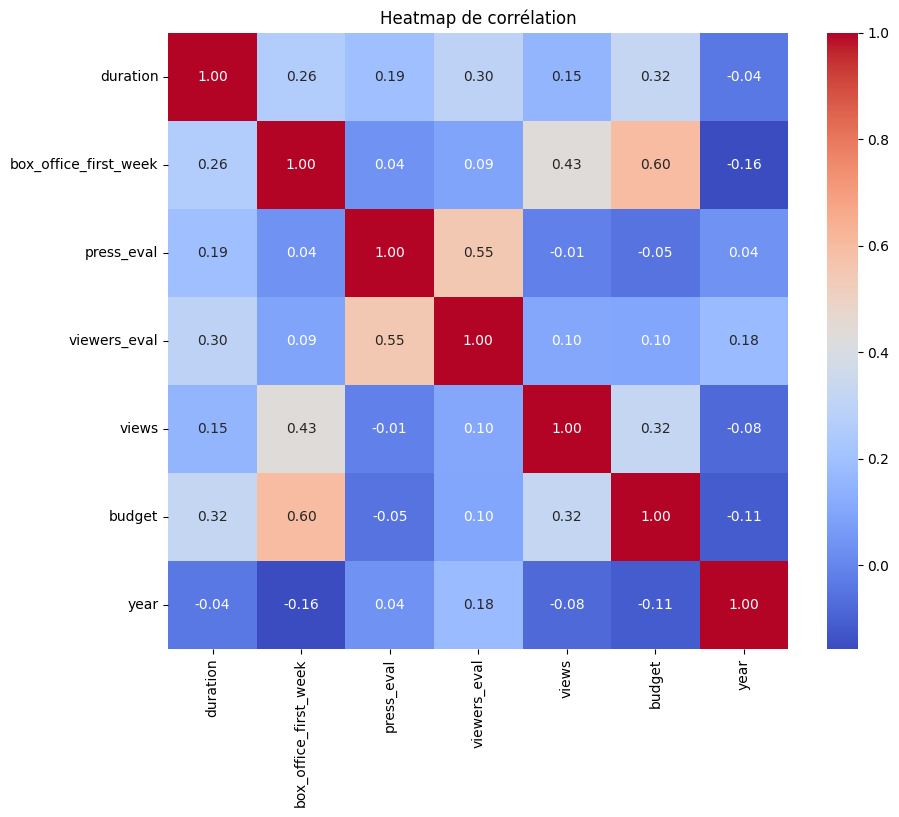

In [25]:
import seaborn as sns

correlation_matrix = df.corr()

# Afficher la heatmap de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation')
plt.show()

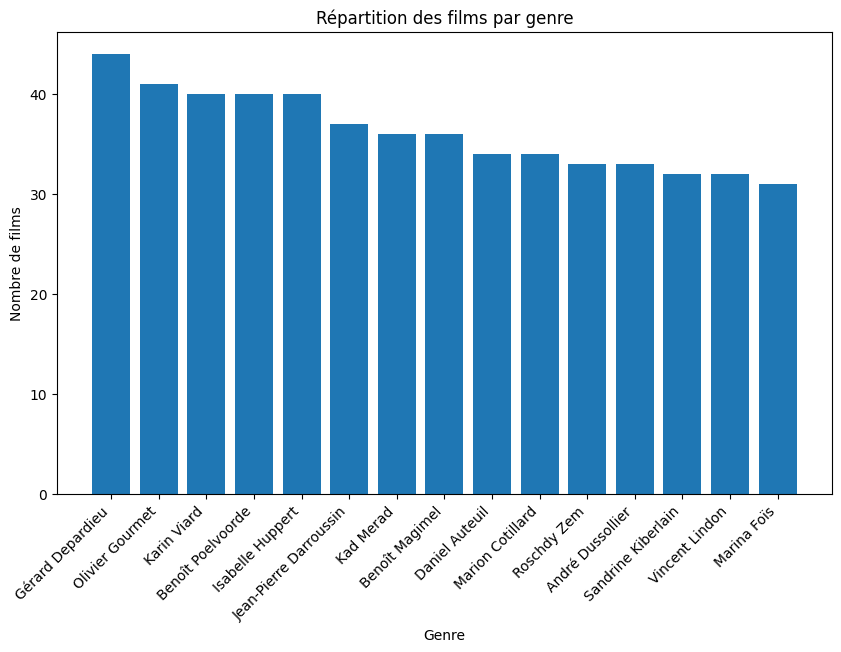

In [26]:
# Compter le nombre de films pour chaque genre
genres_counts = df['cast'].str.split(', ', expand=True).stack().value_counts().head(15)

# Tracer le graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(genres_counts.index, genres_counts.values)
plt.xlabel('Genre')
plt.ylabel('Nombre de films')
plt.title('Répartition des films par genre')
plt.xticks(rotation=45, ha='right')
plt.show()

In [27]:
import os

directory = '/home/apprenant/DevIA/Popularity_corner/popularity_corner'

filename = 'df_cleaned_sans_meteo.csv'
path = os.path.join(directory, filename)

# Changer le répertoire de travail actuel (si nécessaire)
os.chdir(directory)

# Enregistrer le DataFrame dans un fichier CSV
df.to_csv(filename, index=False)